# Transformer with Diffrence ID Dataset

In [1]:
from datetime import datetime
import json
import math
import os
import sys
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
try:
  from google.colab import drive
  IS_GOOGLE_COLAB = True
except ImportError:
  IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  mount_path = '/content/drive'
  base_folder = os.path.join(mount_path, "My Drive", "Data")
  data_folder = os.path.join(base_folder, "FX")
else:
  base_folder = 'L:/data'
  data_folder = os.path.join(base_folder, "fx", "OANDA-Japan MT5 Live")


device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
model_name = "std_close_id_transformer"
model_version = "2"
batch_first = True

# parameters for dataset
close_column = 'close'
time_column = "time"
file_name = "mt5_USDJPY_min30.csv"
file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)

# training parameters
observation_length = 60
prediction_length = 10
lr = 0.001
batch_size = 16
epoch = 100
patience = 3
scheduler_gamma = 0.5

# model parameters
model_params = {
    "nhead": 2,
    "d_model": 10,
    "dim_feedforward": 10,
    "num_encoder_layers": 4,
    "num_decoder_layers": 4,
    # replace after dataset is defined
    "ohlc_size": None,
    "dropout": 0.1,
    "batch_first": batch_first,
}

In [4]:
import os
import shutil
import sys
import zipfile
import requests

def download_modlue_from_gh(repository, github_account='Naradice', branch='master', folder=None, module_path='/gdrive/My Drive/modules', **kwargs):
  if folder is None:
    folder = repository
  print(f"Downloading {repository} from {github_account}/{repository}/{branch}...")

  zip_url = f"https://github.com/{github_account}/{repository}/archive/refs/heads/{branch}.zip"
  response = requests.get(zip_url)
  if response.status_code == 200:
    with open("temp.zip", "wb") as f:
      f.write(response.content)
    with zipfile.ZipFile("temp.zip", "r") as zip_ref:
      zip_ref.extractall("temp_dir")

    if isinstance(folder, str):
      folders = [folder]
    else:
      folders = folder
    for folder in folders:    
      source_folder = f"temp_dir/{repository}-{branch}/{folder}"
      destination_folder = os.path.join(module_path, folder)
      print(f"Copying {source_folder} to {destination_folder}...")
      shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
    os.remove("temp.zip")
    shutil.rmtree("temp_dir")
  else:
    print(f"filed to download {zip_url}: {response.status_code}, {response.text}")

In [5]:
if IS_GOOGLE_COLAB:
  drive.mount(mount_path)
  module_path = f"{mount_path}/My Drive/modules"
else:
  module_path = '../../modules'

if os.path.exists(module_path) is False:
  os.makedirs(module_path)

repositories = [
    {'repository': 'stocknet_study', 'branch': 'master', 'folder': ['Dataset', 'SN_Utils'], 'refresh': False},
    {'repository': 'finance_process', 'branch': 'master', 'folder': 'fprocess', 'refresh': False},
    {'repository': 'cloud_storage_handler', 'branch': 'main', 'folder': 'cloud_storage_handler', 'refresh': False},
]

destination = os.path.join(module_path, '__init__.py')
if os.path.exists(destination) is False:
  with open(destination, mode='w') as fp:
    fp.close()

for repo_kwargs in repositories:
  folders = repo_kwargs['folder']
  if isinstance(folders, str):
    folders = [folders]
  is_missing = False
  for folder in folders:
    destination = os.path.join(module_path, folder)
    if repo_kwargs['refresh'] or os.path.exists(destination) is False:
      is_missing = True
      break
  if is_missing:
    download_modlue_from_gh(**repo_kwargs, module_path=module_path)

In [6]:
sys.path.append(module_path)

import cloud_storage_handler
import SN_Utils

In [7]:
# Initialize cloud storage handler if needed
from cloud_storage_handler import DropboxHandler


# storage_handler = DropboxHandler("nhjrq1cjpugk5hc", "http://localhost")
# storage_handler.authenticate()
# Otherwise, specify None
storage_handler = None

## Define Dataset

In [8]:
import random
from collections.abc import Iterable

import numpy as np
import torch


class CloseDiffSTDIDDS:
    
    def __init__(self, df, close_column, observation_length=60,
                device="cuda", future_step_size=10, seed=1017, is_training=True, batch_first=True):
        self.seed(seed)
        self.columns = close_column
        self.__length_difference = 0
        self.__batch_first = batch_first
        self.__data = df.copy()
        self.ohlc_idf = self.__init_ohlc(df, close_column)
        
        self.observation_length = observation_length
        self.device = device
        self.future_step_size = future_step_size
        self.is_training = is_training
        self.__init_indicies(self.ohlc_idf)
    
    def __init_indicies(self, data, split_ratio=0.8):
        length = len(data) - self.observation_length - self.future_step_size
        if length < 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")
        
        to_index = int(length * split_ratio)
        from_index = 0
        train_indices = list(range(from_index, to_index))
        self.train_indices = random.sample(train_indices, k=to_index - from_index)

        # Note: If unique value exits in validation data only, validation loss would be grater than expected
        from_index = int(length * split_ratio) + self.observation_length + self.future_step_size
        to_index = length
        eval_indices = list(range(from_index, to_index))
        self.eval_indices = random.sample(eval_indices, k=to_index - from_index)
        
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.eval_indices
    
    def std_based_class(self, value, mean, std, max_alpha=3, sf=3):
        """
        This is created for USDJPY
        """
        rounded_value = np.round(value, sf)
        if rounded_value == 0:
            return 0
        MAX_FACTOR = 10
        unit = 1 / MAX_FACTOR
        for id_index, factor in enumerate(range(1, MAX_FACTOR+1)):
            alpha = unit * factor
            if mean - std * alpha <= rounded_value and mean + std * alpha >= rounded_value:
                id = id_index + 1
                if mean > rounded_value:
                    return - id
                else:
                    return id
        
        ID_BASE = MAX_FACTOR + 1

        MAX_FACTOR = 5
        unit = 1 / MAX_FACTOR
        for id_index, factor in enumerate(range(1, MAX_FACTOR+1)):
            alpha = 1 + unit * factor
            if mean - std * alpha <= rounded_value and mean + std * alpha >= rounded_value:
                id = ID_BASE + id_index
                if mean > rounded_value:
                    return - id
                else:
                    return id

        ID_BASE += MAX_FACTOR

        MAX_FACTOR = 2
        unit = 1 / MAX_FACTOR
        for id_index, factor in enumerate(range(1, MAX_FACTOR+1)):
            alpha = 2 + unit * factor
            if mean - std * alpha <= rounded_value and mean + std * alpha >= rounded_value:
                id = ID_BASE + id_index
                if mean > rounded_value:
                    return - id
                else:
                    return id
        
        ID_BASE += MAX_FACTOR
        for id_index, alpha in enumerate(range(2, max_alpha+1)):
            if mean - std * 2 ** alpha <= rounded_value and mean + std * 2 ** alpha >= rounded_value:
                id = ID_BASE + id_index
                if mean > rounded_value:
                    return - id
                else:
                    return id
                    
        ID_BASE += max_alpha - 1 
        if mean > rounded_value:
            return - ID_BASE
        else:
            return ID_BASE
    
    def __init_ohlc(self, df, close_column):
        close_df = df[close_column].diff().dropna()
        self.__length_difference += 1
        close_mean = close_df.mean()
        close_std = close_df.std()
        class_df = close_df.apply(lambda x: self.std_based_class(x, close_mean, close_std))
        self.mean = close_mean
        self.std = close_std
        self.id_min = abs(class_df.min())
        id_df = class_df + self.id_min
        self.vocab_size = id_df.max() + 1
        return id_df
    
    def revert_diff(self, prediction, index, periods=None):
        if periods is None:
            periods = self.__periods
        org_indices = self.get_actual_index(index)
        if self.__with_close:
            if type(org_indices) is int:
                target_index = self.get_target_range(org_indices).start - periods
                last_close = self.__data[self.columns[0]].iloc[target_index].values
            else:
                target_index = [self.get_target_range(i).start - periods for i in org_indices]
                batch_size = len(org_indices)
                last_close = self.__data[self.columns[0]].iloc[target_index].values.reshape(batch_size, 1)
            return last_close + prediction
        else:
            if type(org_indices) is int:
                target_index = self.get_target_range(org_indices).start - periods
                last_value = self.__data[self.columns].iloc[target_index].values
            else:
                target_index = [self.get_target_range(i).start - periods for i in org_indices]
                batch_size = len(org_indices)
                last_value = self.__data[self.columns].iloc[target_index].values.reshape(batch_size, len(self.columns))
            return prediction + last_value
    
    def revert_target(self, tgt_ohlc, indices):
        return None

    def __get_data_set(self, idx):
        ohlc_ids = self.ohlc_idf.iloc[idx].values.tolist()
        return ohlc_ids
    
    def get_target_range(self, index):
        return slice(index + self.observation_length -1, index + self.observation_length + self.future_step_size)

    def _output_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = self.get_target_range(index)
            ohlc_ids = self.__get_data_set(idx)
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int64)
            
            return ohlc_ids
        elif type(batch_size) == slice:    
            ohlc_chunk_data = []            
            for index in self._indices[batch_size]:
                idx = self.get_target_range(index)
                ohlc_ids = self.__get_data_set(idx)
                ohlc_chunk_data.append(ohlc_ids)

            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int64)
            if self.__batch_first is False:
                ohlc_ids = ohlc_ids.transpose(0, 1)
            return ohlc_ids
    
    def get_observation_range(self, index):
        return slice(index, index + self.observation_length)
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = self.get_observation_range(index)
            ohlc_ids = self.__get_data_set(idx)
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int64)

            return ohlc_ids
        elif type(batch_size) == slice:
            ohlc_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = self.get_observation_range(index)
                ohlc_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int64)
            if self.__batch_first is False:
                ohlc_ids = ohlc_ids.transpose(0, 1)
            return ohlc_ids
    
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def seed(self, seed=None):
        '''
        '''
        if seed is None:
            seed = 1192
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed
            
    def eval(self):
        self._indices = self.eval_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = False
    
    def get_index_range(self):
        return min(self._indices), max(self._indices)

    def get_date_range(self):
        min_index, max_index = self.get_index_range()
        return self.__data.index[min_index + self.__length_difference], self.__data.index[max_index + self.__length_difference]
    
    def get_actual_index(self, ndx):
        inputs = []
        if type(ndx) == slice:
            inputs = [index + self.__length_difference for index in self._indices[ndx]]
        elif isinstance(ndx, Iterable):
            for index in ndx:
                inputs.append(self._indices[index] + self.__length_difference)
        else:
            return self._indices[ndx] + self.__length_difference
        return inputs

## Define Model

input diff with positional encoding

output ohlc values with softmax

In [9]:
class WassersteinLoss(nn.Module):
    def __init__(self, class_size, device=None):
        super(WassersteinLoss, self).__init__()
        self.class_size = class_size
        self.device = device

    def forward(self, preds, target_labels):
        """
        preds: Tensor of shape (batch_size, prediction_length, class_size)
        target_labels: LongTensor of shape (batch_size, prediction_length)
        """
        batch_size, seq_len, class_size = preds.shape
        probs = F.softmax(preds, dim=-1)  # shape: (batch, seq, class)

        # one-hot targets: shape (batch, seq, class)
        target = F.one_hot(target_labels, num_classes=class_size).float()

        # cumulative distributions
        pred_cdf = torch.cumsum(probs, dim=-1)
        target_cdf = torch.cumsum(target, dim=-1)

        wasserstein = torch.mean(torch.abs(pred_cdf - target_cdf), dim=-1)  # mean over class dim
        return wasserstein.mean()  # mean over batch and sequence

In [10]:
class NumericalLoss(nn.Module):
    def __init__(self, class_size, sigma=1.0, device=None, eps=1e-8):
        super(NumericalLoss, self).__init__()
        self.class_size = class_size
        self.sigma = sigma
        self.device = device
        self.eps = eps
        self.indices = torch.arange(class_size, device=device).float()  # (class,)

    def forward(self, preds, target_labels):
        """
        preds: (batch, seq_len, class)
        target_labels: (batch, seq_len)
        """
        batch, seq_len, class_size = preds.shape

        targets = target_labels.unsqueeze(-1).float()  # (batch, seq, 1)
        dists = (self.indices.view(1, 1, -1) - targets) ** 2  # (batch, seq, class)
        weights = torch.exp(-dists / (2 * self.sigma ** 2))
        weights = weights / (weights.sum(dim=-1, keepdim=True) + self.eps)

        log_probs = F.log_softmax(preds, dim=-1)
        loss = -torch.sum(weights * log_probs, dim=-1)  # (batch, seq)
        return loss.mean()

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05, batch_first=True):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(-2)
        if batch_first:
            pe = pe.transpose(0, 1)
            self.forward = self.__fforward
        else:
            self.forward = self.__mforward
            
        self.register_buffer("pe", pe)

    def __mforward(self, src, tgt):
        src_pos = src.size(0)
        tgt_pos = src_pos + tgt.size(0) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])
    
    def __fforward(self, src, tgt):
        src_pos = src.size(1)
        tgt_pos = src_pos + tgt.size(1) - 1
        return self.dropout(src + self.pe[:, :src_pos, :]), self.dropout(tgt + self.pe[:, src_pos-1:tgt_pos, :])

In [12]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8, batch_first:bool = False, **kwargs
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim=d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout, batch_first=batch_first)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=batch_first, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=batch_first, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.close_output = nn.Linear(d_model, ohlc_size)
        

    def forward(
        self, src_ohlc: Tensor, tgt_ohlc: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        src = self.ohlc_embedded_layer(src_ohlc)
        tgt = self.ohlc_embedded_layer(tgt_ohlc)
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        close_logits = self.close_output(outs)
        
        return close_logits

In [13]:
def train(model, ds, optimizers, criterion, batch_size, batch_first):
    
    model = model.train()
    ds.train()
    losses = 0
    token_vocab_size = int(ds.vocab_size)

    
    end_index = len(ds) - batch_size
    if batch_first:
        get_tgt_input = lambda tgt: tgt[:, :-1]
        get_tgt_output = lambda tgt: tgt[:, 1:]
        get_length = lambda src: src.size(1)
    else:
        get_tgt_input = lambda tgt: tgt[:-1, :]
        get_tgt_output = lambda tgt: tgt[1:, :]
        get_length = lambda src: src.size(0)
    
    for index in tqdm(range(0, end_index, batch_size)):
        ohlc_src, ohlc_tgt = ds[index:index+batch_size]
        in_ohlc_tgt = get_tgt_input(ohlc_tgt)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(get_length(in_ohlc_tgt)).to(device)
        logits_c  = model(
            src_ohlc=ohlc_src, tgt_ohlc=in_ohlc_tgt, mask_tgt=mask_tgt
        )

        out_ohlc_tgt = get_tgt_output(ohlc_tgt)
        #print(logits_o.shape, out_ohlc_tgt.shape)
        # out_ohlc_tgt = torch.nn.functional.one_hot(out_ohlc_tgt.to(dtype=torch.long), token_vocab_size).to(dtype=logits_c.dtype)
        
        for optimizer in optimizers:
            optimizer.zero_grad()
        
        c_loss = criterion(logits_c, out_ohlc_tgt)
        
        c_loss.backward()
        for optimizer in optimizers:
            optimizer.step()
            
        losses += c_loss.item()
    
    losses = losses/end_index
    return losses

In [14]:
def evaluate(model, ds, criterion, batch_size, batch_first):
    
    model = model.eval()
    ds.eval()
    losses = 0
    end_index = len(ds) - batch_size
    token_vocab_size = int(ds.vocab_size)

    if batch_first:
        get_tgt_input = lambda tgt: tgt[:, :-1]
        get_tgt_output = lambda tgt: tgt[:, 1:]
        get_length = lambda src: src.size(1)
    else:
        get_tgt_input = lambda tgt: tgt[:-1, :]
        get_tgt_output = lambda tgt: tgt[1:, :]
        get_length = lambda src: src.size(0)

    for index in range(0, end_index, batch_size):
        ohlc_src, ohlc_tgt = ds[index:index+batch_size]
        in_ohlc_tgt = get_tgt_input(ohlc_tgt)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(get_length(in_ohlc_tgt)).to(device)
        logits_c  = model(
            src_ohlc=ohlc_src, tgt_ohlc=in_ohlc_tgt, mask_tgt=mask_tgt
        )

        out_ohlc_tgt = get_tgt_output(ohlc_tgt)
        #print(logits_o.shape, out_ohlc_tgt.shape)
        # out_ohlc_tgt = torch.nn.functional.one_hot(out_ohlc_tgt.to(dtype=torch.long), token_vocab_size).to(dtype=logits_c.dtype)
        
        c_loss = criterion(logits_c, out_ohlc_tgt)
        losses += c_loss.item()
    
    losses = losses/end_index
    return losses

## Training

In [15]:
df = pd.read_csv(file_path, parse_dates=[time_column], index_col=0)
ds = CloseDiffSTDIDDS(df, close_column, observation_length=observation_length,
                device=device, future_step_size=prediction_length, seed=1017, batch_first=batch_first, is_training=True)
model_params['ohlc_size'] = int(ds.vocab_size)

In [16]:
model = Seq2SeqTransformer(**model_params)

params_num = 0
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    if p.requires_grad:
        params_num += p.numel()
print(f"params: {params_num}")

model = model.to(device)

params: 8301


In [17]:
logger = SN_Utils.Logger(
    version=model_version,
    model_name=model_name,
    storage_handler=storage_handler
)

In [18]:
start_index, end_index = ds.get_date_range()
params = {"processes": None,
          "source": {
              "path": file_path,
              "start": start_index.isoformat(),
              "end": end_index.isoformat(),
              "length": len(ds)
          },
          "features": [close_column],
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          **model_params,
          "params_num": params_num,
          # format version
          "version": 2
}

logger.save_params(params, model_name, model_version)

print("training log will be saved on ", logger.log_file_path)

training log will be saved on  ./std_close_id_transformer\std_close_id_transformer_v2.csv


In [19]:
criterion = NumericalLoss(model_params['ohlc_size'], device=device)
# criterion = nn.CrossEntropyLoss()
# criterion = WassersteinLoss(model_params['ohlc_size'])
optimizer_common = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler_common = torch.optim.lr_scheduler.StepLR(optimizer_common, 1.0, gamma=scheduler_gamma)

In [ ]:
model.train()
ds.train()
best_loss = float('Inf')
best_model = None
model = best_model
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizers=[optimizer_common],
        criterion=criterion, batch_size=batch_size, batch_first=batch_first
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size, batch_first=batch_first
    )
    
    print(f'{loop}/{epoch} {str(int(math.floor(elapsed_time / 60))) + "m" if math.floor(elapsed_time / 60) > 0 else ""}{elapsed_time % 60}s count: {counter}, \
        {loss_train}, {loss_valid}\
        {"**" if best_loss > loss_valid else ""}')
    logger.add_training_log(loss_train, loss_valid, log_entry=[loss_train, loss_valid, elapsed_time])
    if loss_valid == torch.nan:
        break
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        logger.save_model(best_model)
    else:
        counter += 1
        scheduler_common.step()
    if counter > patience:
        break

100%|██████████| 2516/2516 [01:36<00:00, 26.05it/s]


1/100 1m36.59719157218933s count: 0,         0.10376301857957321, 0.10226861141817        **


100%|██████████| 2516/2516 [01:35<00:00, 26.40it/s]


2/100 1m35.31004309654236s count: 0,         0.10375832465695993, 0.1022662135900936        **


100%|██████████| 2516/2516 [01:38<00:00, 25.56it/s]


3/100 1m38.42041993141174s count: 0,         0.10374950022806873, 0.10223979853050472        **


100%|██████████| 2516/2516 [01:39<00:00, 25.34it/s]


4/100 1m39.2900116443634s count: 0,         0.10374954162184939, 0.10224975444657707        


100%|██████████| 2516/2516 [01:38<00:00, 25.60it/s]


5/100 1m38.28912925720215s count: 1,         0.10370872072767287, 0.10218688841467968        **


100%|██████████| 2516/2516 [01:39<00:00, 25.19it/s]


6/100 1m39.883795976638794s count: 0,         0.10369307838704975, 0.1022265001354709        


100%|██████████| 2516/2516 [01:40<00:00, 25.03it/s]


7/100 1m40.53191161155701s count: 1,         0.10367935182548021, 0.10218519806885686        **


100%|██████████| 2516/2516 [01:38<00:00, 25.59it/s]


8/100 1m38.30399513244629s count: 0,         0.10367132725275395, 0.10217302860269914        **


100%|██████████| 2516/2516 [01:38<00:00, 25.63it/s]


9/100 1m38.15197944641113s count: 0,         0.10366868417662069, 0.10217293497567075        **


100%|██████████| 2516/2516 [01:37<00:00, 25.82it/s]


10/100 1m37.44348978996277s count: 0,         0.1036681932778998, 0.10218992290654914        


100%|██████████| 2516/2516 [01:37<00:00, 25.80it/s]


11/100 1m37.505789279937744s count: 1,         0.1036571298347077, 0.10217631140559025        


100%|██████████| 2516/2516 [01:37<00:00, 25.92it/s]


12/100 1m37.071368932724s count: 2,         0.10364876835618181, 0.10215889557597879        **


100%|██████████| 2516/2516 [01:37<00:00, 25.81it/s]


13/100 1m37.48073363304138s count: 0,         0.10365346385764761, 0.10215964480648265        


100%|██████████| 2516/2516 [01:38<00:00, 25.60it/s]


14/100 1m38.28109169006348s count: 1,         0.10364625938772223, 0.10215149206483772        **


100%|██████████| 2516/2516 [01:37<00:00, 25.68it/s]


15/100 1m37.97138786315918s count: 0,         0.10364640647575565, 0.10214997411655147        **


100%|██████████| 2516/2516 [01:37<00:00, 25.76it/s]


16/100 1m37.671618700027466s count: 0,         0.10364486770772542, 0.10215046921484909        


100%|██████████| 2516/2516 [01:37<00:00, 25.79it/s]


17/100 1m37.5448431968689s count: 1,         0.10364307146824668, 0.10214846663211238        **


100%|██████████| 2516/2516 [01:37<00:00, 25.88it/s]


18/100 1m37.23450040817261s count: 0,         0.10364706221793582, 0.10215175391100637        


100%|██████████| 2516/2516 [01:36<00:00, 26.09it/s]


19/100 1m36.44484901428223s count: 1,         0.10363871186247037, 0.10214995341503813        


100%|██████████| 2516/2516 [01:36<00:00, 26.15it/s]


20/100 1m36.228557109832764s count: 2,         0.10364034371763078, 0.10214812147991134        **


100%|██████████| 2516/2516 [01:36<00:00, 26.02it/s]


21/100 1m36.69082593917847s count: 0,         0.10364318090672003, 0.10214842745518289        


100%|██████████| 2516/2516 [01:36<00:00, 25.96it/s]


22/100 1m36.912172079086304s count: 1,         0.10363655293716673, 0.10214854037902159        


100%|██████████| 2516/2516 [01:36<00:00, 25.98it/s]


23/100 1m36.83369851112366s count: 2,         0.10363602969122351, 0.10214820505974177        


100%|██████████| 2516/2516 [01:36<00:00, 26.05it/s]


24/100 1m36.59837627410889s count: 3,         0.10364268215520736, 0.10214793860662333        **


100%|██████████| 2516/2516 [01:36<00:00, 26.07it/s]


25/100 1m36.504212617874146s count: 0,         0.10363883403840306, 0.102148108789967        


100%|██████████| 2516/2516 [01:36<00:00, 26.00it/s]


26/100 1m36.76660752296448s count: 1,         0.10363661505153532, 0.10214822805877787        


100%|██████████| 2516/2516 [01:36<00:00, 26.06it/s]


27/100 1m36.54418873786926s count: 2,         0.10363923764109444, 0.10214822493986096        


100%|██████████| 2516/2516 [01:36<00:00, 26.16it/s]


28/100 1m36.16748023033142s count: 3,         0.10363979627643922, 0.10214824618897039        


## Evaluation

In [20]:
from SN_Utils import utils

params, model, _, _ = utils.load_model(model_name, Seq2SeqTransformer, model_version, device, 
    torch.optim.AdamW, torch.optim.lr_scheduler.StepLR, train=False,model_folder="./")

In [21]:
sample_index = 0
model = model.eval()
ds.eval()

input_data, tgt_data = ds[sample_index:sample_index+10]

In [20]:
pre_tgt = input_data[:, -1:]
logits = model(input_data, pre_tgt, None)
logits.shape

torch.Size([10, 1, 41])

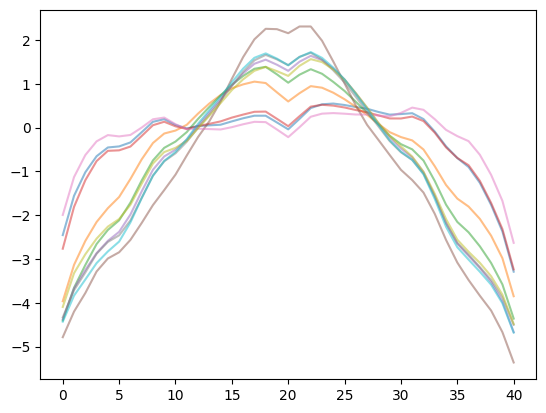

In [21]:
import matplotlib.pyplot as plt

for batch in range(10):
    plt.plot(logits[batch, -1].cpu().detach().numpy(), label="pred", alpha=0.5)

In [22]:
for _ in range(1, 10):
    scores, ids = torch.topk(logits, k=1)
    pre_tgt = torch.concat((pre_tgt, ids[:, -1:, 0]), dim=-1)
    logits = model(input_data, pre_tgt, None)

In [23]:
pre_tgt

tensor([[ 4, 24, 23, 23, 23, 23, 23, 17, 23, 18],
        [28, 17, 22, 18, 22, 18, 22, 18, 22, 18],
        [24, 18, 22, 18, 22, 18, 22, 18, 22, 18],
        [ 8, 23, 23, 23, 22, 22, 22, 22, 22, 22],
        [15, 22, 22, 22, 18, 22, 18, 22, 18, 22],
        [19, 22, 22, 22, 18, 22, 22, 22, 18, 22],
        [ 5, 31, 17, 23, 23, 23, 23, 17, 23, 17],
        [18, 22, 18, 22, 18, 22, 18, 22, 18, 22],
        [13, 22, 22, 22, 22, 22, 22, 22, 22, 18],
        [18, 22, 18, 22, 18, 22, 18, 22, 18, 22]])

In [95]:
tgt_data

tensor([[ 4, 35, 19, 25, 19, 25, 18, 30, 18, 13, 17],
        [28,  8,  9, 28, 19, 20, 22, 19, 22, 16, 18],
        [24, 17, 29, 28, 15, 17, 13, 28, 27, 14, 13],
        [ 8, 29, 15, 15, 10, 13,  8, 33, 31, 22, 17],
        [15, 17, 25, 22, 16, 22, 24, 23, 19,  6, 26],
        [19, 21, 18, 21, 21, 17, 17, 21, 21, 27, 10],
        [ 5, 29,  1, 28, 13, 38, 32, 22,  6, 22, 31],
        [18, 22, 24, 19, 33, 24, 33, 14,  7, 16, 31],
        [13, 16, 22, 21, 23, 22, 21, 21,  6, 24, 22],
        [18, 17, 25, 22, 23, 15, 17, 22, 14, 14, 23]])

### make id to value range

In [43]:
def id_to_int(ds, tgt):
    if isinstance(tgt, torch.Tensor):
        tgt = tgt.detach().cpu().numpy()
    tgt_int = tgt - ds.id_min
    return tgt_int

In [44]:
def revert_std_based_class(id_value, mean, std, max_alpha=3):
        def return_range(pre_value, current_value, is_negative):
            if is_negative:
                return (current_value, pre_value)
            else:
                return (pre_value, current_value)

        if id_value == 0:
            return (0, 0)

        if id_value < 0:
            sign = -1
            is_negative = True
        else:
            sign = 1
            is_negative = False
        abs_id = abs(id_value)

        MAX_FACTOR = 10
        unit = 1 / MAX_FACTOR
        if abs_id <= MAX_FACTOR:
            # for id_index, factor in enumerate(range(1, MAX_FACTOR+1)):
            pre_alpha = unit * (abs_id -1)
            alpha = unit * abs_id

            if abs_id == 1:
                pre_value = 0
            else:
                pre_value = mean + sign * std * pre_alpha
            value = mean + sign * std * alpha
            return return_range(pre_value, value, is_negative)

        ID_BASE = MAX_FACTOR + 1
        MAX_FACTOR = 5
        if abs_id <= ID_BASE + MAX_FACTOR:
            unit = 1 / MAX_FACTOR
            # for id_index, factor in enumerate(range(1, MAX_FACTOR+1)):
            factor = abs_id - ID_BASE
            pre_alpha = 1 + unit * factor
            alpha = 1 + unit * (factor + 1)
            
            pre_value = mean + sign * std * pre_alpha
            value = mean + sign * std * alpha
            return return_range(pre_value, value, is_negative)

        ID_BASE += MAX_FACTOR
        MAX_FACTOR = 2
        if abs_id <= ID_BASE + MAX_FACTOR:
            unit = 1 / MAX_FACTOR
            # for id_index, factor in enumerate(range(1, MAX_FACTOR+1)):
            factor = abs_id - ID_BASE
            pre_alpha = 2 + unit * factor
            alpha = 2 + unit * (factor + 1)

            pre_value = mean + sign * std * pre_alpha
            value = mean + sign * std * alpha
            return return_range(pre_value, value, is_negative)

        ID_BASE += MAX_FACTOR
        if abs_id < ID_BASE + (max_alpha-1):
            # for id_index, alpha in enumerate(range(2, max_alpha+1)):
            pre_alpha = abs_id - ID_BASE + 1
            alpha = pre_alpha + 1
            

            pre_value = mean + sign * std * 2 ** pre_alpha
            value = mean + sign * std * 2 ** alpha
            return return_range(pre_value, value, is_negative)

        pre_value = mean + sign * std * 2 ** max_alpha
        # value = sign * np.inf
        value = mean + sign * std * 2 ** (max_alpha*2)
        return return_range(pre_value, value, is_negative)

In [45]:
make_id_range = np.vectorize(lambda x: revert_std_based_class(x, ds.mean, ds.std))

In [123]:
pre_tgt_int = id_to_int(ds, pre_tgt)
lower_values, upper_values = make_id_range(pre_tgt_int)

In [124]:
tgt_int = id_to_int(ds, tgt_data)
lower_tgt_values, upper_tgt_values = make_id_range(tgt_int)

In [88]:
a_index = ds.get_actual_index(sample_index)
answers_df = df.iloc[a_index + observation_length -2: a_index + observation_length + 10]

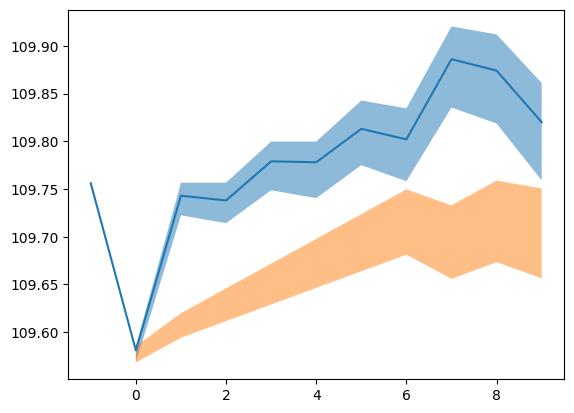

In [ ]:
initial_values = answers_df["close"].iloc[0]

# market values
plt.plot([-1, 0,1,2,3,4,5,6,7,8,9], answers_df["close"].values[:-1])
# answer range
plt.fill_between([0,1,2,3,4,5,6,7,8,9], initial_values + np.cumsum(lower_tgt_values[0, :-1]), initial_values + np.cumsum(upper_tgt_values[0, :-1]), alpha = 0.5)
# prediction range
plt.fill_between([0,1,2,3,4,5,6,7,8,9], initial_values + np.cumsum(lower_values[0]), initial_values + np.cumsum(upper_values[0]), alpha = 0.5)

### show value range with beam search

In [36]:
def joint_beam_search(model, input_data, beam_width, max_len, batch_first=True):
    if batch_first:
        batch_size = input_data.shape[0]
        preds_ohlc = input_data[:, -1:]
        length_dim = 1
        batch_dim = 0
        get_last_tensor = lambda x: x[:, -1:]
    else:
        raise Exception("batch_first should be True")
        batch_size = input_data.shape[1]
        preds_ohlc = input_data[-1:]
        length_dim = 0
        batch_dim = 1
        get_last_tensor = lambda x: x[-1:]

    # first prediction
    logits_c  = model(
        src_ohlc=input_data, tgt_ohlc=preds_ohlc,
        mask_tgt=None, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
        memory_key_padding_mask=None
    )

    # make beam
    scores_c, indices_c = torch.topk(logits_c, k=beam_width, dim=-1)
    preds = preds_ohlc.repeat_interleave(beam_width, dim=batch_dim)
    beam_indices = indices_c.reshape(batch_size*beam_width, 1)
    preds = torch.cat([preds, beam_indices], dim=length_dim)
    ohlc_src_beam = input_data.repeat_interleave(beam_width, dim=batch_dim)
    total_scores = scores_c.view(batch_size * beam_width, 1).expand(-1, beam_width)  # [batch*beam, beam]


    for _ in range(1, max_len):
        # next prediction
        logits_c  = model(
            src_ohlc=ohlc_src_beam, tgt_ohlc=preds,
            mask_tgt=None, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        next_scores_c, next_indices_c = torch.topk(logits_c, k=beam_width, dim=-1)
        # transform for simplicity
        next_log_probs = next_scores_c[:, -1].squeeze(1)
        next_tokens = next_indices_c[:, -1].squeeze(1)
        # caliculate joint score
        total_scores = total_scores + next_log_probs  # [batch*beam, beam]
        current_scores = total_scores.view(batch_size, beam_width * beam_width)
        next_tokens = next_tokens.contiguous().view(batch_size, beam_width * beam_width)
        # calculate new top k
        topk_scores, topk_indices = torch.topk(current_scores, beam_width, dim=-1)  # [batch, beam]
        # topk_indices から元のビームと追加トークンを復元
        # どのビームからきたか（元ビームのインデックス）と、どのトークンか
        beam_indices = topk_indices // beam_width  # 元のビーム index (0〜beam_width-1)
        token_indices = topk_indices % beam_width  # next_token のインデックス
        # 新しい sequence を組み立てる
        new_sequences = []
        for b in range(batch_size):
            beams = []
            for i in range(beam_width):
                prev_seq = preds[(b * beam_width + beam_indices[b, i]), -1:]
                next_token = next_tokens[b, topk_indices[b, i]]
                beams.append(torch.cat([prev_seq, next_token.view(1)]))
            new_sequences.append(torch.stack(beams))
        new_sequences = torch.stack(new_sequences)  # [batch_size, beam_width, step+1]

        # 更新された結果
        new_preds = new_sequences.reshape(batch_size * beam_width, -1) # [batch, beam, step+1] -> [batch*beam, step+1]
        preds = torch.cat([preds, new_preds[:, -1:]], dim=length_dim)
        beam_scores = topk_scores            # [batch, beam]
    return preds, total_scores

In [23]:
sample_index = 0
ds.eval()

input_data, tgt_data = ds[sample_index:sample_index+2]

In [24]:
# tgt_length, batch_size, feature_size = tgt_data.shape
if batch_first:
    print(tgt_data[0, :])
else:
    print(tgt_data[:, 0])

tensor([ 4, 35, 19, 25, 19, 25, 18, 30, 18, 13, 17])


In [25]:
# check sample_tgt_indices are valid
sample_tgt_indices = ds.get_target_range(ds._indices[sample_index])
id_df = ds.ohlc_idf.iloc[sample_tgt_indices]
id_df

time
2021-07-08 23:30:00     4
2021-07-09 00:00:00    35
2021-07-09 00:30:00    19
2021-07-09 01:00:00    25
2021-07-09 01:30:00    19
2021-07-09 02:00:00    25
2021-07-09 02:30:00    18
2021-07-09 03:00:00    30
2021-07-09 03:30:00    18
2021-07-09 04:00:00    13
2021-07-09 04:30:00    17
Name: close, dtype: int64

In [26]:
# check original values and indices
index_org = ds.get_actual_index(sample_index)
sample_tgt_indices_org = ds.get_target_range(index_org)
tgt_org = df[close_column].iloc[sample_tgt_indices_org]

# print original values
print("Original values: Target")
print(tgt_org)

Original values: Target
time
2021-07-08 23:30:00    109.581
2021-07-09 00:00:00    109.743
2021-07-09 00:30:00    109.738
2021-07-09 01:00:00    109.779
2021-07-09 01:30:00    109.778
2021-07-09 02:00:00    109.813
2021-07-09 02:30:00    109.802
2021-07-09 03:00:00    109.886
2021-07-09 03:30:00    109.874
2021-07-09 04:00:00    109.820
2021-07-09 04:30:00    109.801
Name: close, dtype: float64


In [37]:
# caliculate predictions with model
model = model.eval()
preds_ohlc, _ = joint_beam_search(model, input_data, beam_width=3, max_len=10, batch_first=batch_first)

In [40]:
preds_ohlc[:3]

tensor([[ 4, 24, 23, 23, 23, 23, 23, 23, 23, 23, 22],
        [ 4, 23, 22, 23, 23, 23, 23, 17, 17, 17, 17],
        [ 4, 25, 24, 23, 23, 23, 17, 23, 22, 22, 23]])

In [41]:
a_index = ds.get_actual_index(sample_index)
answers_df = df.iloc[a_index + observation_length -2: a_index + observation_length + 10]

In [47]:
tgt_int = id_to_int(ds, tgt_data)
lower_tgt_values, upper_tgt_values = make_id_range(tgt_int)

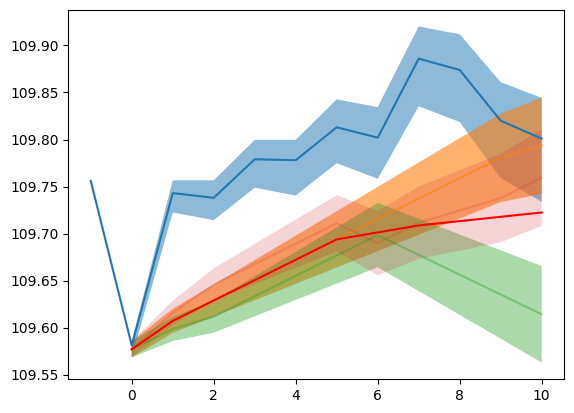

In [64]:
import matplotlib.pyplot as plt

initial_values = answers_df["close"].iloc[0]

# market values
plt.plot([-1, 0,1,2,3,4,5,6,7,8,9, 10], answers_df["close"].values)
# answer range
plt.fill_between([0,1,2,3,4,5,6,7,8,9,10], initial_values + np.cumsum(lower_tgt_values[0]), initial_values + np.cumsum(upper_tgt_values[0]), alpha = 0.5)
# prediction range for beams
beam_mean_values = None
for beam in range(3):
    pre_tgt_int = id_to_int(ds, preds_ohlc[beam])
    lower_values, upper_values = make_id_range(pre_tgt_int)
    plt.fill_between([0,1,2,3,4,5,6,7,8,9, 10], initial_values + np.cumsum(lower_values), initial_values + np.cumsum(upper_values), alpha = 0.2 * (3 - beam))
    mean_values = initial_values + np.cumsum((lower_values + upper_values) / 2)
    plt.plot([0,1,2,3,4,5,6,7,8,9, 10], mean_values , alpha=0.2 * (3 - beam))
    if beam_mean_values is None:
        beam_mean_values = mean_values
    else:
        beam_mean_values += mean_values
beam_mean_values = beam_mean_values / 3
plt.plot([0,1,2,3,4,5,6,7,8,9, 10], beam_mean_values, color="red")

In [66]:
preds_ohlc

tensor([[ 4, 24, 23, 23, 23, 23, 23, 23, 23, 23, 22],
        [ 4, 23, 22, 23, 23, 23, 23, 17, 17, 17, 17],
        [ 4, 25, 24, 23, 23, 23, 17, 23, 22, 22, 23],
        [28, 17, 22, 22, 22, 22, 22, 22, 22, 22, 22],
        [28, 18, 18, 18, 22, 18, 22, 18, 22, 22, 18],
        [28, 16, 23, 18, 18, 18, 18, 22, 18, 18, 22]])

In [72]:
test = preds_ohlc.reshape(2, 3, -1)

In [87]:
test[:, 0]

tensor([[ 4, 24, 23, 23, 23, 23, 23, 23, 23, 23, 22],
        [28, 17, 22, 22, 22, 22, 22, 22, 22, 22, 22]])

In [91]:
lower_values, upper_values = make_id_range(id_to_int(ds, test))

In [93]:
(lower_values + upper_values)/2

array([[[-0.17913697,  0.03021769,  0.0216726 ,  0.0216726 ,
          0.0216726 ,  0.0216726 ,  0.0216726 ,  0.0216726 ,
          0.0216726 ,  0.0216726 ,  0.01312751],
        [-0.17913697,  0.0216726 ,  0.01312751,  0.0216726 ,
          0.0216726 ,  0.0216726 ,  0.0216726 , -0.02105284,
         -0.02105284, -0.02105284, -0.02105284],
        [-0.17913697,  0.03876278,  0.03021769,  0.0216726 ,
          0.0216726 ,  0.0216726 , -0.02105284,  0.0216726 ,
          0.01312751,  0.01312751,  0.0216726 ]],

       [[ 0.06439804, -0.02105284,  0.01312751,  0.01312751,
          0.01312751,  0.01312751,  0.01312751,  0.01312751,
          0.01312751,  0.01312751,  0.01312751],
        [ 0.06439804, -0.01250775, -0.01250775, -0.01250775,
          0.01312751, -0.01250775,  0.01312751, -0.01250775,
          0.01312751,  0.01312751, -0.01250775],
        [ 0.06439804, -0.02959793,  0.0216726 , -0.01250775,
         -0.01250775, -0.01250775, -0.01250775,  0.01312751,
         -0.01250775,

In [96]:
indices = ds.get_actual_index(slice(sample_index, sample_index+2))

In [99]:
ans_batch_values = []
for a_index in indices:
    ans_values = df["close"].iloc[a_index + observation_length -2: a_index + observation_length + 10].diff().dropna().values
    ans_batch_values.append(ans_values)
np.asanyarray(ans_batch_values).shape

(2, 11)

In [101]:
ans_batch_values

[array([-0.175,  0.162, -0.005,  0.041, -0.001,  0.035, -0.011,  0.084,
        -0.012, -0.054, -0.019]),
 array([ 0.064, -0.115, -0.1  ,  0.062, -0.003,  0.   ,  0.014, -0.005,
         0.012, -0.031, -0.009])]

In [103]:
np.asanyarray(ans_batch_values).T.shape

(11, 2)

## Evaluate with validation data

In [104]:
ds.eval()
model = model.eval()

BEAM_WIDTH = 3

ans_ids = None
ans_diffs = None
pre_ids = None
pre_diffs = None

if batch_first:
    batch_dim = 0
else:
    batch_dim = 1

start_time = time.time()
for index in range(0, len(ds), batch_size):
    if len(ds) - index < batch_size:
        ndx = slice(index, len(ds))
        indices = [i for i in range(index, len(ds))]
        B = len(ds) - index
    else:
        ndx = slice(index, index+batch_size)
        indices = [i for i in range(index, index+batch_size)]
        B = batch_size
    val_inp, val_ans = ds[ndx]
            
    preds_ids_candidates, _ = joint_beam_search(model, val_inp, beam_width=3, max_len=prediction_length, batch_first=batch_first)
    if batch_first:
        pre_batch_ids = preds_ids_candidates.reshape(B, BEAM_WIDTH, -1)
    else:
        pre_batch_ids = preds_ids_candidates.reshape(-1, B, BEAM_WIDTH)
    pre_batch_ids = id_to_int(ds, pre_batch_ids)
    lower_values, upper_values = make_id_range(pre_batch_ids)
    mean_pre_values = (lower_values + upper_values)/2

    # convert tgt to id_int
    ans_batch_ids = id_to_int(ds, val_ans)

    # retrieve original diffs from df
    indices = ds.get_actual_index(ndx)
    ans_batch_values = []
    for a_index in indices:
        ans_values = df["close"].iloc[a_index + observation_length -2: a_index + observation_length + 10].diff().dropna().values
        ans_batch_values.append(ans_values)
    ans_batch_values = np.asanyarray(ans_batch_values)
    if batch_first is False:
        ans_batch_values = ans_batch_values.T

    # save them
    if pre_ids is None:
        pre_ids = pre_batch_ids
        pre_diffs = mean_pre_values
    else:
        pre_ids = np.concatenate([pre_ids, pre_batch_ids], axis=batch_dim)
        pre_diffs = np.concatenate([pre_diffs, mean_pre_values], axis=batch_dim)

    if ans_ids is None:
        ans_ids = ans_batch_ids
        ans_diffs = ans_batch_values
    else:
        ans_ids = np.concatenate([ans_ids, ans_batch_ids], axis=batch_dim)
        ans_diffs = np.concatenate([ans_diffs, ans_batch_values], axis=batch_dim)

Compare difference between answer values and predicted values

In [117]:
if batch_first:
    diff_id_array = pre_ids - ans_ids[:, np.newaxis, :]
    diff_values_array = pre_diffs - ans_diffs[:, np.newaxis, :]
    mean_diff_values_array = pre_diffs.mean(axis=1) - ans_diffs
    len_dim = 1
else:
    diff_id_array = pre_ids - ans_ids[:, :, np.newaxis]
    diff_values_array = pre_diffs - ans_diffs[:, :, np.newaxis]
    mean_diff_values_array = pre_diffs.mean(axis=2) - ans_diffs
    len_dim = 0

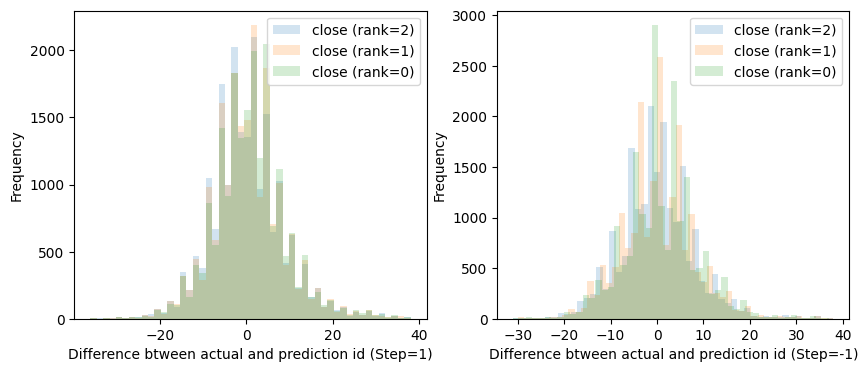

In [145]:
import matplotlib.pyplot as plt

if batch_first:
    get_feature_by_step = lambda array, step, rank: array[:, rank, step]
else:
    get_feature_by_step = lambda array, step, rank: array[step, :, rank]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# plot difference of id for first and last prediction
steps = [1, -1]
for x, step in enumerate(steps):
    for rank in range(BEAM_WIDTH-1, -1, -1):
        axs[x].hist(get_feature_by_step(diff_id_array, step, rank), bins=50, alpha=0.2)
    axs[x].set_xlabel(f'Difference btween actual and prediction id (Step={step})')
    axs[x].set_ylabel('Frequency')
    axs[x].legend([f'close (rank={rank})' for rank in range(BEAM_WIDTH-1, -1, -1)])
plt.show()

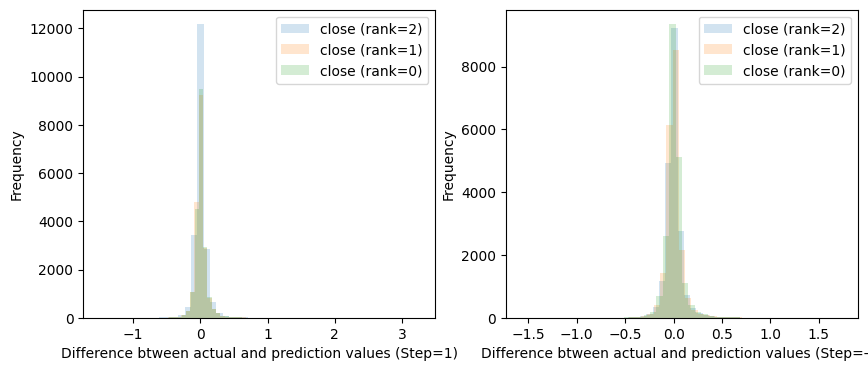

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# plot difference of value for first and last prediction
steps = [1, -1]
for x, step in enumerate(steps):
    for rank in range(BEAM_WIDTH-1, -1, -1):
        axs[x].hist(get_feature_by_step(diff_values_array, step, rank), bins=50, alpha=0.2)
    axs[x].set_xlabel(f'Difference btween actual and prediction values (Step={step})')
    axs[x].set_ylabel('Frequency')
    axs[x].legend([f'close (rank={rank})' for rank in range(BEAM_WIDTH-1, -1, -1)])
plt.show()

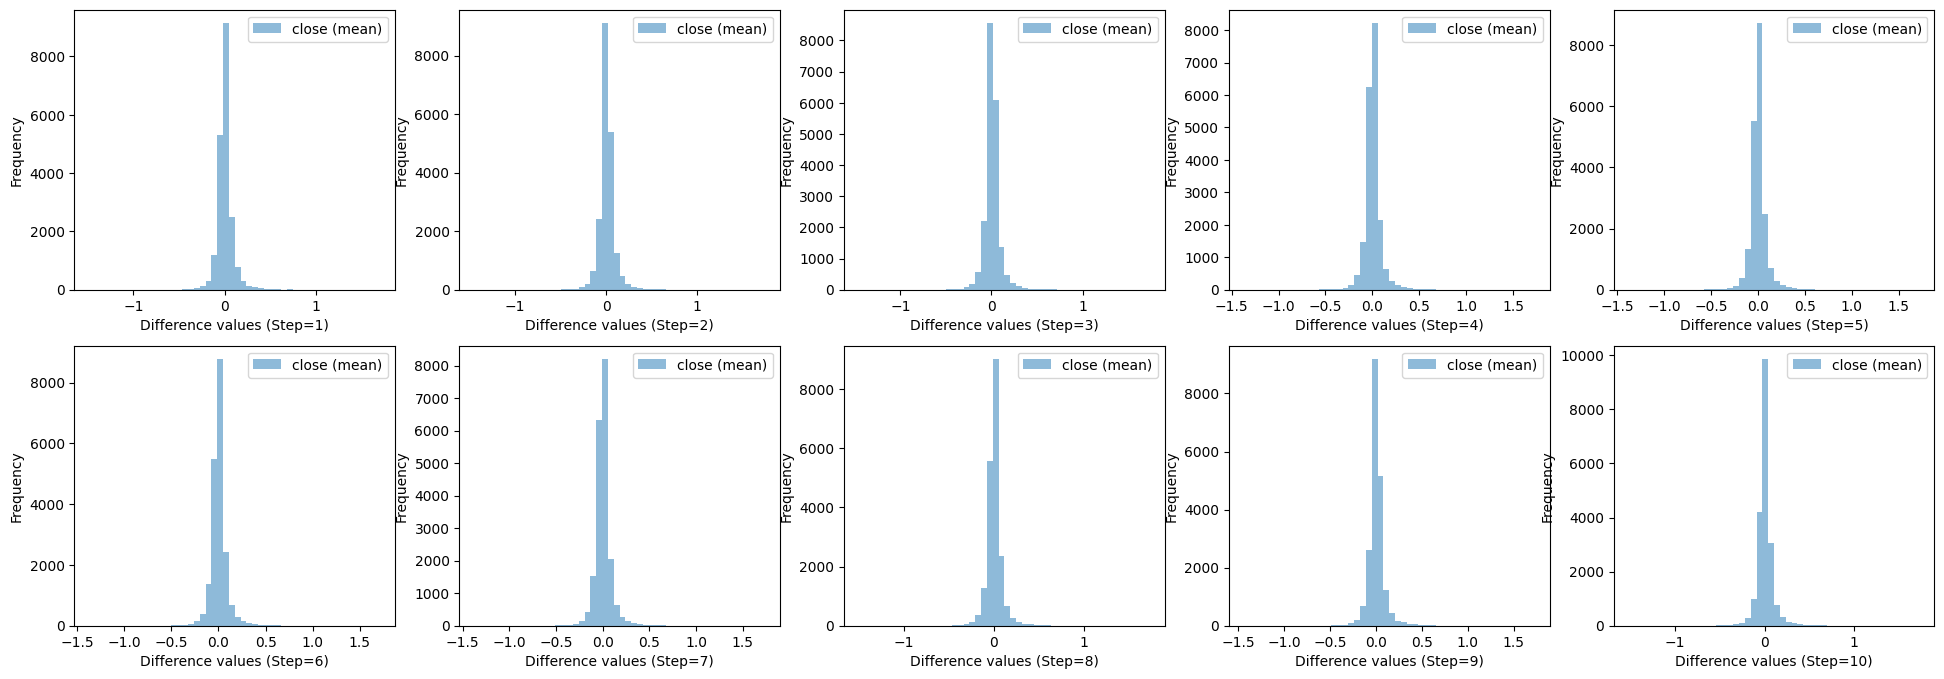

In [153]:
fig, axs = plt.subplots(2, 5, figsize=(24, 8))

# plot difference of value for first and last prediction (mean)
for step in range(1, prediction_length+1):
    x = (step -1) % 5
    y = (step-1) // 5
    axs[y, x].hist(mean_diff_values_array[:, step], bins=50, alpha=0.5)
    axs[y, x].set_xlabel(f'Difference values (Step={step})')
    axs[y, x].set_ylabel('Frequency')
    axs[y, x].legend(['close (mean)'])
plt.show()

In [160]:
diff_indicator_mean = [diff_values_array[:, rank].mean(axis=0) for rank in range(BEAM_WIDTH)]
diff_indicator_mean.append(mean_diff_values_array.mean(axis=0))
diff_indicator_mean = pd.DataFrame(diff_indicator_mean, index=["rank0", "rank1", "rank2", "beam_mean"]).T
diff_indicator_mean

,rank0,rank1,rank2,beam_mean
0,0.000090,0.000090,0.000090,0.000090
1,0.008423,0.006215,0.004140,0.006259
2,0.010952,0.006853,0.005298,0.007701
3,0.010754,0.008548,0.005312,0.008205
4,0.009019,0.005488,0.003250,0.005919
5,0.008548,0.004842,0.002221,0.005204
6,0.007879,0.004922,0.002287,0.005029
7,0.008841,0.006487,0.003650,0.006326
8,0.008909,0.006505,0.003763,0.006392
9,0.008582,0.006624,0.003987,0.006398


In [192]:
diff_indicator_var = [diff_values_array[:, rank].var(axis=0) for rank in range(BEAM_WIDTH)]
diff_indicator_var.append(mean_diff_values_array.var(axis=0))
diff_indicator_var = pd.DataFrame(diff_indicator_var, index=["rank0", "rank1", "rank2", "beam_var"]).T
diff_indicator_var

,rank0,rank1,rank2,beam_var
0,0.002725,0.002725,0.002725,0.002725
1,0.008352,0.008622,0.009985,0.008153
2,0.007972,0.008061,0.008169,0.007727
3,0.007871,0.007946,0.008150,0.007707
4,0.007956,0.008082,0.008178,0.007817
5,0.007947,0.008018,0.008327,0.007866
6,0.007872,0.007875,0.008101,0.007730
7,0.007841,0.007914,0.008096,0.007742
8,0.007778,0.007884,0.008034,0.007699
9,0.007963,0.008061,0.008278,0.007904


[]

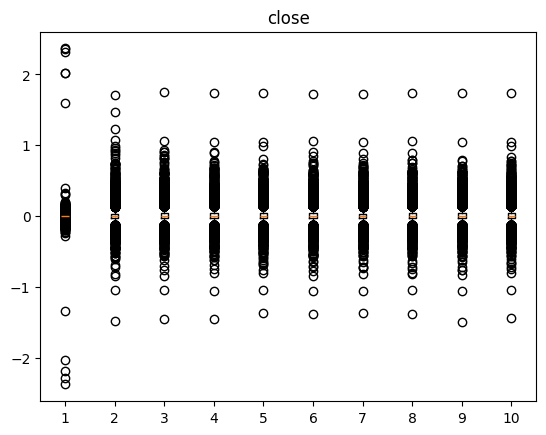

In [168]:
quant_1_df = pd.DataFrame(np.quantile(mean_diff_values_array, 0.25, axis=batch_dim), columns=["close_diff"])
quant_2_df = pd.DataFrame(np.quantile(mean_diff_values_array, 0.5, axis=batch_dim), columns=["close_diff"])
quant_3_df = pd.DataFrame(np.quantile(mean_diff_values_array, 0.75, axis=batch_dim), columns=["close_diff"])
min_df = pd.DataFrame(np.min(mean_diff_values_array, axis=batch_dim), columns=["close_diff"])
max_df = pd.DataFrame(np.max(mean_diff_values_array, axis=batch_dim), columns=["close_diff"])

# plot quantile values with prediction steps
for index in range(0, 10):
  plt.boxplot(mean_diff_values_array[:, index], positions=[index+1])

plt.title('close')
plt.plot()

[]

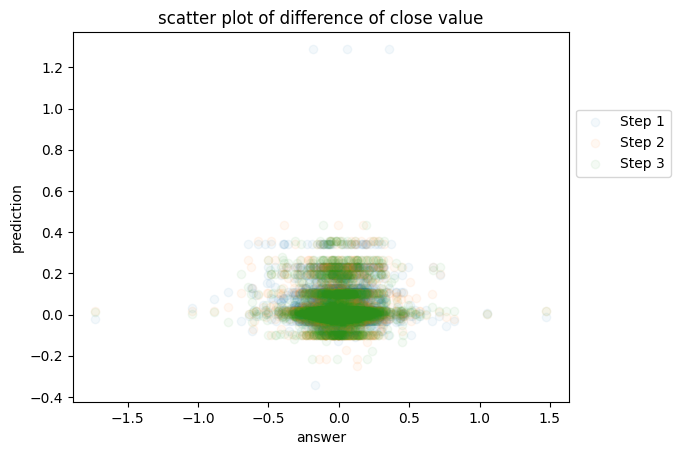

In [178]:
for step in range(1, 4):
  plt.scatter(ans_diffs[:, step], pre_diffs.mean(axis=1)[:, step], label=f'Step {step}', alpha=0.05)
plt.xlabel("answer")
plt.ylabel("prediction")
plt.title('scatter plot of difference of close value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.plot()

In [182]:
diff_array_org = ans_diffs - pre_diffs.mean(axis=1)
mean_org_df = pd.DataFrame(np.mean(diff_array_org, axis=batch_dim), columns=["mean_error"])
var_org_df = pd.DataFrame(np.var(diff_array_org, axis=batch_dim), columns=["std_error"])

print(mean_org_df)
print(var_org_df)

    mean_error
0    -0.000090
1    -0.006259
2    -0.007701
3    -0.008205
4    -0.005919
5    -0.005204
6    -0.005029
7    -0.006326
8    -0.006392
9    -0.006398
10   -0.004422
    std_error
0    0.002725
1    0.008153
2    0.007727
3    0.007707
4    0.007817
5    0.007866
6    0.007730
7    0.007742
8    0.007699
9    0.007904
10   0.008005


[]

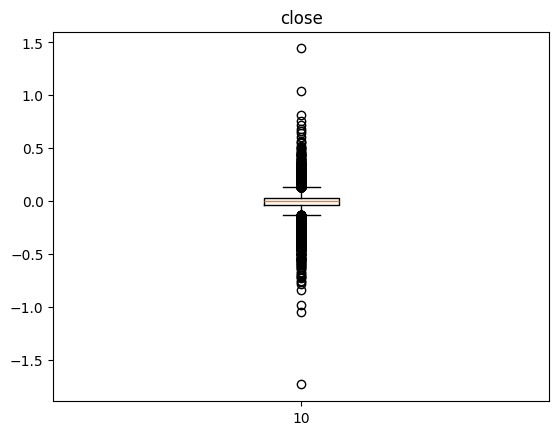

In [187]:
quant_1_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.25, axis=batch_dim), columns=["close"])
quant_2_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.5, axis=batch_dim), columns=["close"])
quant_3_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.75, axis=batch_dim), columns=["close"])
min_org_df = pd.DataFrame(np.min(diff_array_org, axis=batch_dim), columns=["close"])
max_org_df = pd.DataFrame(np.max(diff_array_org, axis=batch_dim), columns=["close"])

plt.boxplot(diff_array_org[:, index], positions=[index+1])
plt.title('close')
plt.plot()

In [193]:
validation_file_path = f'{base_folder}/{model_name}/{model_name}_v{model_version}_validation.csv'
validation_df = pd.concat([
    diff_indicator_mean, diff_indicator_var, quant_1_df, quant_2_df, quant_3_df, min_df, max_df,
    mean_org_df, var_org_df, quant_1_org_df, quant_2_org_df, quant_3_org_df, min_org_df, max_org_df,
    ],
    keys=[
        "mean", "var", "q1", "q2", "q3", "min", "max",
        "org_mean", "org_var", "org_q1", "org_q2", "org_q3", "org_min", "org_max"
        ],
    axis=1)
os.makedirs(os.path.dirname(validation_file_path), exist_ok=True)
validation_df.to_csv(validation_file_path)
if storage_handler is not None:
    destination_file_path = f'/{model_name}/{model_name}_v{model_version}_validation.csv'
    storage_handler.upload_file(validation_file_path, destination_file_path)

In [194]:
validation_df

mean                                     var                      \
       rank0     rank1     rank2 beam_mean     rank0     rank1     rank2   
0   0.000090  0.000090  0.000090  0.000090  0.002725  0.002725  0.002725   
1   0.008423  0.006215  0.004140  0.006259  0.008352  0.008622  0.009985   
2   0.010952  0.006853  0.005298  0.007701  0.007972  0.008061  0.008169   
3   0.010754  0.008548  0.005312  0.008205  0.007871  0.007946  0.008150   
4   0.009019  0.005488  0.003250  0.005919  0.007956  0.008082  0.008178   
5   0.008548  0.004842  0.002221  0.005204  0.007947  0.008018  0.008327   
6   0.007879  0.004922  0.002287  0.005029  0.007872  0.007875  0.008101   
7   0.008841  0.006487  0.003650  0.006326  0.007841  0.007914  0.008096   
8   0.008909  0.006505  0.003763  0.006392  0.007778  0.007884  0.008034   
9   0.008582  0.006624  0.003987  0.006398  0.007963  0.008061  0.008278   
10  0.006680  0.004353  0.002234  0.004422  0.008078  0.008271  0.008323   

                     q1         q2         q3        min        max  \
    beam_var close_diff close_diff close_diff close_diff close_diff   
0   0.002725  -0.002598  -0.000053   0.002492  -2.379922   2.365542   
1   0.008153  -0.031327   0.000682   0.034431  -1.486508   1.707947   
2   0.007727  -0.028418   0.004431   0.037582  -1.455176   1.747824   
3   0.007707  -0.027872   0.005128   0.038128  -1.458024   1.742128   
4   0.007817  -0.030069   0.002582   0.036155  -1.373997   1.733582   
5   0.007866  -0.031772   0.001579   0.034991  -1.379694   1.725037   
6   0.007730  -0.030963   0.001582   0.034700  -1.373997   1.719186   
7   0.007742  -0.029963   0.002758   0.036427  -1.379694   1.742128   
8   0.007699  -0.029673   0.003103   0.036582  -1.499325   1.733582   
9   0.007904  -0.029963   0.002228   0.036228  -1.442358   1.733582   
10  0.008005  -0.031963   0.000427   0.033682  -1.524961   1.733582   

     org_mean   org_var    org_q1    org_q2    org_q3   org_min   org_max  
   mean_error std_error     close     close     close     close     close  
0   -0.000090  0.002725 -0.002492  0.000053  0.002598 -2.365542  2.379922  
1   -0.006259  0.008153 -0.034431 -0.000682  0.031327 -1.707947  1.486508  
2   -0.007701  0.007727 -0.037582 -0.004431  0.028418 -1.747824  1.455176  
3   -0.008205  0.007707 -0.038128 -0.005128  0.027872 -1.742128  1.458024  
4   -0.005919  0.007817 -0.036155 -0.002582  0.030069 -1.733582  1.373997  
5   -0.005204  0.007866 -0.034991 -0.001579  0.031772 -1.725037  1.379694  
6   -0.005029  0.007730 -0.034700 -0.001582  0.030963 -1.719186  1.373997  
7   -0.006326  0.007742 -0.036427 -0.002758  0.029963 -1.742128  1.379694  
8   -0.006392  0.007699 -0.036582 -0.003103  0.029673 -1.733582  1.499325  
9   -0.006398  0.007904 -0.036228 -0.002228  0.029963 -1.733582  1.442358  
10  -0.004422  0.008005 -0.033682 -0.000427  0.031963 -1.733582  1.524961